In [22]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


# Groundwater Level (WTE) Data Quality Check

Analysis objectives:
1. Time coverage and data points
   - Check if there are ≥3 points for interpolation
   - Verify seasonal distribution of measurements
2. Anomaly detection
   - Sudden changes/jumps in values
   - Significant noise
   - Duplicate values (instrument issues)

In [33]:
import os
import pandas as pd

file_path = '../data/raw/groundwater/GSLB_1900-2023_TS_with_aquifers.csv'

if os.path.exists(file_path):
    wte_data = pd.read_csv(file_path)
    wte_data['Date'] = pd.to_datetime(wte_data['Date'])
    print("File loaded successfully!")
else:
    print(f"File not found: {file_path}. Please make sure the file exists at the specified path.")

File loaded successfully!


In [34]:
# Basic statistics and data quality check
def check_wte_data_quality(df, well_id):
    well_data = df[df['Well_ID'] == well_id].copy()
    well_data = well_data.sort_values('Date')

    # Check number of measurements
    n_measurements = len(well_data)

    # Check time coverage
    date_range = well_data['Date'].max() - well_data['Date'].min()
    seasons_covered = well_data['Date'].dt.quarter.nunique()

    # Check for duplicates
    duplicates = well_data[well_data.duplicated(['Date', 'WTE'], keep=False)]

    # Calculate sudden changes
    well_data['wte_change'] = well_data['WTE'].diff()
    large_changes = well_data[abs(well_data['wte_change']) > well_data['wte_change'].std() * 3]

    return {
        'well_id': well_id,
        'n_measurements': n_measurements,
        'date_range_days': date_range.days,
        'seasons_covered': seasons_covered,
        'n_duplicates': len(duplicates),
        'n_large_changes': len(large_changes)
    }

In [35]:
# Analyze all wells
well_ids = wte_data['Well_ID'].unique()
quality_reports = []

for well_id in well_ids[:10]:  # Limiting to 10 wells for demonstration
    report = check_wte_data_quality(wte_data, well_id)
    quality_reports.append(report)

quality_df = pd.DataFrame(quality_reports)

KeyError: 'wte_change'

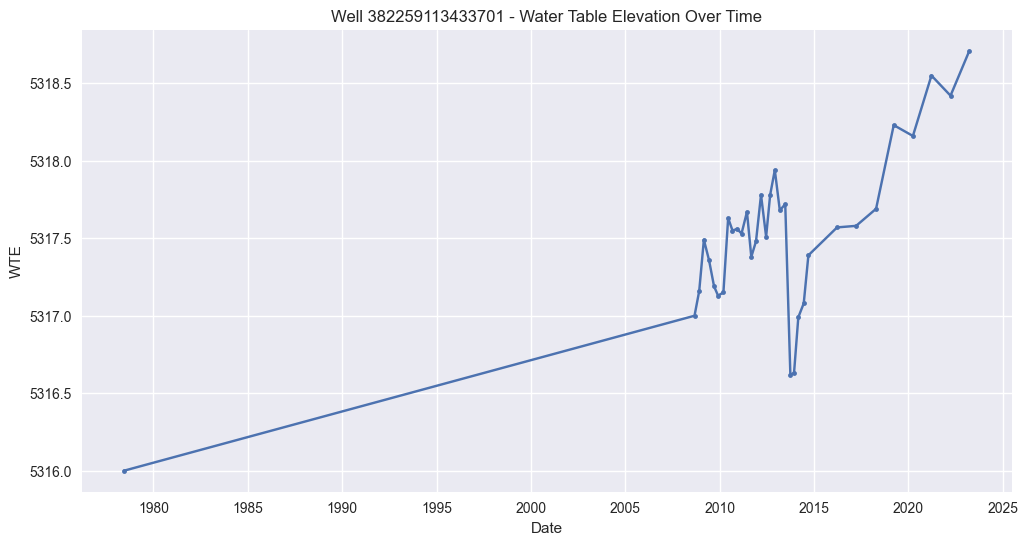

In [36]:
# Plot example well with potential issues
def plot_well_data(df, well_id):
    well_data = df[df['Well_ID'] == well_id].sort_values('Date')

    plt.figure(figsize=(12, 6))
    plt.plot(well_data['Date'], well_data['WTE'], '.-')
    plt.title(f'Well {well_id} - Water Table Elevation Over Time')
    plt.xlabel('Date')
    plt.ylabel('WTE')
    plt.grid(True)

    # Highlight potential issues
    duplicates = well_data[well_data.duplicated(['Date', 'WTE'], keep=False)]
    if len(duplicates) > 0:
        plt.scatter(duplicates['Date'], duplicates['WTE'],
                    color='red', label='Duplicates')

    large_changes = well_data[abs(well_data['wte_change']) > well_data['wte_change'].std() * 3]
    if len(large_changes) > 0:
        plt.scatter(large_changes['Date'], large_changes['WTE'],
                    color='orange', label='Large changes')

    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()


# Plot first well with issues
problem_well = quality_df[
    (quality_df['n_duplicates'] > 0) | (quality_df['n_large_changes'] > 0)
    ].iloc[0]['well_id']
plot_well_data(wte_data, problem_well)